In [154]:
import polars as pl
from polars import testing
import numpy as np
from matplotlib import pyplot as plt

evaluation_ds = pl.read_parquet('/home/ubuntu/experiments/test_batch_training/predictions.parquet')
test_ds = pl.read_parquet('/home/ubuntu/experiments/preprocessing_validation_small_new/validation_ds.parquet')

In [155]:
evaluation_ds = evaluation_ds.with_columns(
            pl.col('prediction') / pl.col('prediction').sum().over('impression_id')
        )
     

In [156]:

evaluation_ds = evaluation_ds.with_columns(
            (pl.col('prediction')-pl.col('prediction').min().over('impression_id')) / 
             (pl.col('prediction').max().over('impression_id')-pl.col('prediction').min().over('impression_id'))
        )
     

In [113]:
test_ds = test_ds.drop('target')

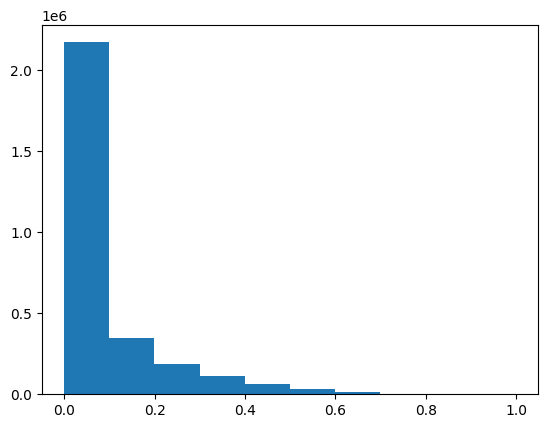

In [116]:
plt.hist(evaluation_ds.select('prediction').to_numpy())
plt.show()
statistics = evaluation_ds.select('prediction').describe(percentiles=  (0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99))
positive_val =  statistics.filter(pl.col('statistic') == "99%").select('prediction').item()
negative_val =  statistics.filter(pl.col('statistic') == "10%").select('prediction').item()

In [120]:
POSITIVE_THRESHOLD = positive_val
NEGATIVE_THRESHOLD = negative_val
POSITIVE_THRESHOLD = 0.80
# NEGATIVE_THRESHOLD = 0.05
print(statistics)
print(POSITIVE_THRESHOLD)
print(evaluation_ds.filter(pl.col('prediction') > POSITIVE_THRESHOLD).unique('impression_id').shape[0])
print(NEGATIVE_THRESHOLD)
print(evaluation_ds.filter(pl.col('prediction') < NEGATIVE_THRESHOLD).unique('impression_id').shape[0])

shape: (16, 2)
┌────────────┬────────────┐
│ statistic  ┆ prediction │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 2.928942e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.083527   │
│ std        ┆ 0.127522   │
│ min        ┆ 0.000003   │
│ …          ┆ …          │
│ 75%        ┆ 0.105591   │
│ 90%        ┆ 0.257045   │
│ 95%        ┆ 0.364793   │
│ 99%        ┆ 0.569261   │
│ max        ┆ 0.998082   │
└────────────┴────────────┘
0.8
5183
0.001629342885049528
73380


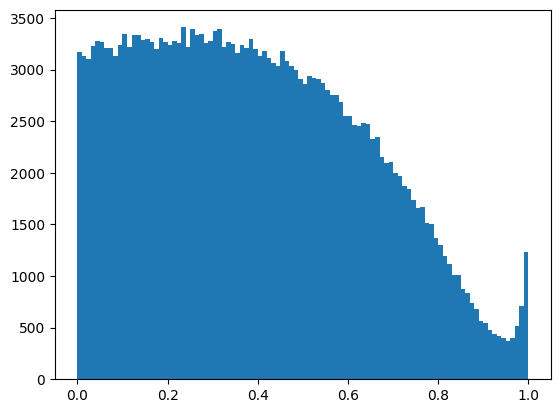

statistic,head_diff
str,f64
"""count""",244647.0
"""null_count""",0.0
"""mean""",0.394458
"""std""",0.245319
"""min""",1.1523e-7
…,…
"""75%""",0.578109
"""90%""",0.73882
"""95%""",0.820656


In [158]:
NPRATIO = 2
head_diff = evaluation_ds.sort('prediction')\
        .group_by('impression_id').agg(pl.col('article'),pl.col('prediction'))\
            .with_columns(
                pl.col('prediction').list.len().alias('impression_len')
            ) \
            .filter(pl.col('impression_len')>= NPRATIO + 1)\
            .with_columns(
                pl.col('prediction').list.last().alias('highest_pos'),
                pl.col('prediction').list.gather(-2).list.last().alias('second_positive'),
            )\
            .with_columns(
                (pl.col('highest_pos') - pl.col('second_positive')).alias('head_diff')
            ).select('head_diff')
plt.hist(head_diff.to_numpy(), bins=100)
plt.show()
head_diff.describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.98))

In [159]:
NPRATIO = 2
DIFF_THRESHOLD = 0.90
selected_index = evaluation_ds.sort('prediction')\
        .group_by('impression_id').agg(pl.col('article'),pl.col('prediction'))\
            .with_columns(
                pl.col('prediction').list.len().alias('impression_len')
            ) \
            .filter(pl.col('impression_len')>= NPRATIO + 1)\
            .with_columns(
                pl.col('prediction').list.last().alias('highest_pos'),
                pl.col('article').list.last().alias('positive_element'),
                pl.col('prediction').list.gather(-2).list.last().alias('second_positive'),
                pl.col('prediction').list.head(NPRATIO).alias('highest_negatives'),
                pl.col('article').list.head(NPRATIO).alias('negative_element')
            )\
            .with_columns(
                  pl.col('highest_negatives').list.to_struct().struct.rename_fields([f'negative_score_{i}' for i in range(NPRATIO)]),
                  pl.col('negative_element').list.to_struct().struct.rename_fields([f'negative_{i}' for i in range(NPRATIO)]),
            )\
            .unnest('highest_negatives','negative_element')\
            .filter((pl.col('highest_pos') - pl.col('second_positive')) > DIFF_THRESHOLD) \
            .select(['impression_id', 'positive_element'] + [f'negative_{i}' for i in range(NPRATIO)])  
            # .filter(
            #     pl.all_horizontal(
            #         *[pl.col(f'negative_score_{i}') < NEGATIVE_THRESHOLD for i in range(NPRATIO)]
            #     )
            # ).select(['impression_id', 'positive_element'] + [f'negative_{i}' for i in range(NPRATIO)])   
self_ds_positive = selected_index.select(['impression_id', 'positive_element'])\
    .rename({'positive_element' :'article'})\
    .join(test_ds, on = ['impression_id','article'], how = 'left').with_columns(target = pl.Series([1]))
    
self_ds_negative = selected_index.select(['impression_id'] + [f'negative_{i}' for i in range(NPRATIO)])\
    .with_columns(
        pl.concat_list([pl.col(f'negative_{i}') for i in range(NPRATIO)]).alias('article')
    )\
    .select(['impression_id', 'article'])\
    .explode('article')\
    .join(test_ds, on = ['impression_id','article'], how = 'left').with_columns(target = pl.Series([0]))

In [160]:
self_ds = self_ds_positive.vstack(self_ds_negative)
self_ds_len = self_ds.shape[0]
test_ds_len = test_ds.shape[0]

assert self_ds.filter(pl.col('target') == 1).shape[0] == ((self_ds_len)/(NPRATIO + 1))
assert self_ds.filter(pl.col('target') == 0).shape[0] == ((self_ds_len * NPRATIO)/(NPRATIO + 1))
print(self_ds_len)
print(f'% of new elements : {self_ds_len/test_ds_len}')

16452
% of new elements : 0.0056170453358243356


In [161]:
self_ds

impression_id,article,user_id,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score_3d,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_ORG_Present,Entity_PER_Present,Entity_MISC_Present,Entity_LOC_Present,Entity_EVENT_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,…,kurtosis_impression_std_JS,kurtosis_impression_total_read_time,kurtosis_impression_endorsement_10h_leak,kurtosis_impression_trendiness_score_3d_leak,kurtosis_impression_clicked_count,kurtosis_impression_inview_count,category_diversity_impression,sentiment_label_diversity_impression,article_type_diversity_impression,article_delay_hours_rank_impression,std_JS_rank_impression,mean_topics_mean_delay_hours_rank_impression,trendiness_score_3d_rank_impression,trendiness_score_5d_rank_impression,endorsement_10h_rank_impression,total_pageviews/inviews_rank_impression,mean_JS_rank_impression,mean_topic_model_cosine_rank_impression,topics_cosine_rank_impression,total_pageviews_rank_impression,total_read_time_rank_impression,total_inviews_rank_impression,trendiness_score_category_rank_impression,endorsement_10h_leak_rank_impression,trendiness_score_3d_leak_rank_impression,clicked_count_rank_impression,inview_count_rank_impression,mean_JS_l_inf_user,std_JS_l_inf_user,mean_topic_model_cosine_l_inf_user,topics_cosine_l_inf_user,article_delay_hours_l_inf_article,mean_JS_l_inf_article,std_JS_l_inf_article,mean_topic_model_cosine_l_inf_article,topics_cosine_l_inf_article,endorsement_20h_articleuser_l_inf_articleuser
u32,i32,u32,i8,f32,f32,bool,i8,i8,bool,i64,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,…,f32,f32,f32,f32,f32,f32,u8,u8,u8,u8,u8,u32,u8,u8,u8,u32,u8,u8,u8,u32,u32,u32,u8,u8,u8,u32,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
118604006,9784702,1430967,3,4.0,null,false,2,null,false,1,338,7,7,false,142,0.7025,"""Positive""",1,7,19,208,4,0,10,false,true,true,false,true,true,8,8.833333,-11,true,false,0.357143,…,-1.741625,NaN,-0.877432,-0.231015,-1.5,-0.24068,4,3,2,1,5,1,1,1,1,1,3,1,4,1,1,1,1,2,1,null,1,0.529759,0.733097,1.0,0.689979,0.097087,0.104917,0.348533,0.924335,0.689979,1.0
154978027,9788862,1477508,1,6.0,null,false,2,null,false,1,105,2,20,false,457,0.9525,"""Negative""",3,6,20,360,4,0,1,true,true,true,false,true,false,4,4.0,62,false,false,0.027778,…,-0.438611,NaN,-1.699915,-0.464687,-0.668656,-0.867655,4,2,2,1,3,1,2,2,2,1,3,5,3,1,1,1,5,1,2,null,3,0.399174,0.472553,0.895637,0.816308,0.027778,0.288924,0.598984,0.838859,0.81064,0.5
54989871,9788898,310588,1,6.0,null,false,2,null,false,1,364,2,22,false,142,0.7004,"""Neutral""",3,5,13,221,5,0,5,false,true,true,false,true,false,0,16.0,168,false,false,0.37037,…,-0.779978,-1.361185,1.94864,0.391814,0.249941,1.858509,5,3,1,1,9,4,1,1,2,7,6,8,10,7,7,7,1,4,1,null,7,0.55641,0.506648,0.876796,0.621273,0.135135,0.234691,0.443813,0.831962,0.632423,1.0
370222260,9787230,111950,1,3.0,null,false,2,null,false,1,49,2,6,false,118,0.9553,"""Negative""",1,12,17,286,3,0,6,false,true,true,false,true,false,0,12.0,-46,true,false,0.268519,…,-1.313606,NaN,-1.396475,-1.562199,-0.67699,-0.24311,3,3,1,1,3,2,4,4,1,1,5,5,1,1,1,1,3,3,4,null,4,0.20711,0.500974,0.800322,0.89873,0.111111,0.123086,0.393351,0.758934,0.89873,0.5
90061216,9781535,1506246,1,5.0,null,false,2,null,false,1,171,5,6,false,414,0.92,"""Positive""",1,7,16,284,4,0,9,true,true,true,false,true,true,0,1.0625,-132,true,false,0.089431,…,-1.001827,-0.324607,0.274989,-0.441439,-1.598373,0.544074,4,3,1,1,8,5,7,7,1,2,6,6,5,2,2,3,4,1,7,null,3,0.612482,0.694041,0.847425,0.71306,0.0703125,0.217586,0.40871,0.854006,0.71306,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,

In [162]:
self_ds.write_parquet('/home/ubuntu/experiments/test_batch_training/self_supervised_ds.parquet')